In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras
from sklearn.metrics import precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, Activation, UpSampling1D
from tensorflow.keras.layers import add, multiply, GlobalAveragePooling1D
from keras import  backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot


In [ ]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [ ]:
from sklearn.preprocessing import StandardScaler

def scale_data(trainX, testX):
 # remove overlap
 cut = int(trainX.shape[1] / 2)
 longX = trainX[:, -cut:, :]
 # flatten windows
 longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
 # flatten train and test
 flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
 flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))

 s = StandardScaler()
 # fit on training data
 s.fit(longX)
 # apply to training and test data
 longX = s.transform(longX)
 flatTrainX = s.transform(flatTrainX)
 flatTestX = s.transform(flatTestX)
 # reshape
 flatTrainX = flatTrainX.reshape((trainX.shape))
 flatTestX = flatTestX.reshape((testX.shape))
 return flatTrainX, flatTestX


In [ ]:
trainX, testX = scale_data(trainX, testX)

In [ ]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [ ]:
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

In [ ]:
class_breakdown(y_train)

Class=1, total=870, percentage=16.906
Class=2, total=754, percentage=14.652
Class=3, total=670, percentage=13.020
Class=4, total=900, percentage=17.489
Class=5, total=964, percentage=18.733
Class=6, total=988, percentage=19.199


In [ ]:
class_breakdown(y_val)

Class=1, total=356, percentage=16.138
Class=2, total=319, percentage=14.461
Class=3, total=316, percentage=14.325
Class=4, total=386, percentage=17.498
Class=5, total=410, percentage=18.586
Class=6, total=419, percentage=18.994


In [ ]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]
n_timesteps, n_features, n_outputs

(128, 9, 6)

In [ ]:
def conv_block(in_x, nb_filter, kernel_size):

    x = Conv1D(nb_filter, kernel_size, padding='same')(in_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [ ]:
def convolutional_block(in_x, nb_filters, stride):

    F1, F2, F3 = nb_filters

    x = in_x

    x = Conv1D(F1, 3, strides=stride,  padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(F2, 3, strides=1, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(F3, 1, strides=1, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)

    #----------------------------------------------

    x1 = Conv1D(F3, 1, strides=stride, padding='same', kernel_initializer="he_normal")(in_x)
    x1 = BatchNormalization()(x1)

    x = add([x, x1])
    x = Activation('relu')(x)

    return x

Attention layer는 CNN에서 이미지의 특정 부분에 집중하여 모델이 해당 부분을 더 잘 이해하고 활용할 수 있도록 도와줌. 모델은 이미지의 중요한 특성을 감지하고 강조할 수 있다.


In [ ]:
def attention_branch(in_x, nb_filter, kernel_size):

    x1 = conv_block(in_x, nb_filter, kernel_size)
    x = MaxPooling1D(2)(x1)

    x = conv_block(x, nb_filter, kernel_size)
    x = UpSampling1D(size = 2)(x)

    x2 = conv_block(x, nb_filter, kernel_size)
# k.int_shape 함수는 텐서의 크기를 나타냄
    if(K.int_shape(x1)!=K.int_shape(x2)):
        x2 = ZeroPadding1D(1)(x2)
        # zeropadding은 0의 패딩을 사용하여 양쪽에 0 데이터 하나씩 추가
        x2 = Cropping1D((1,0))(x2)
        # Crooping1D는 양쪽에서 1개의 요소를 잘라냄.
    x = add([x1, x2])

    x = conv_block(x, nb_filter, kernel_size)

    x = Conv1D(nb_filter, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    return x

In [ ]:
#Residual-Based Temporal Attention Block

def RTA_block(in_x, nb_filter, kernel_size):

    x1 = conv_block(in_x, nb_filter, kernel_size)
    x2 = conv_block(x1, nb_filter, kernel_size)

    attention_map = attention_branch(x1, nb_filter, kernel_size)

    x = multiply([x2, attention_map])
    # multiply 층은 입력받는 두 요소를 같은 위치의 데이터를 곱함
    # ResNET 구조에서 shortcut connection에 사용된다,
    x = add([x, x1])

    out = conv_block(x, nb_filter, kernel_size)

    return out

In [ ]:
def RTA_CNN():

    inputs = Input(shape=(n_timesteps,n_features))
    # input shape는 (none, 128, 9)


    # RTA_block(이전 층, 필터 개수, 필터 크기)
    x = RTA_block(inputs, 64, 32)
    # (none, 128, 16)
    x = MaxPooling1D(2)(x)
    # (none, 64, 16)

    x = RTA_block(x, 64, 32)
    # (none, 64, 16)
    x = MaxPooling1D(2)(x)
    # (none, 32, 16)

    #x = RTA_block(x, 16, 32)
    # (none, 32, 16)
    #x = MaxPooling1D(2)(x)

    x = Dropout(0.6)(x)

    x = Flatten()(x)
    #x = Dropout(0.7)(x)
    x = Dense(100,  activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(n_outputs,  activation='softmax')(x)

    model = keras.Model(inputs, x)

    return model

In [ ]:
model = RTA_CNN()
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 conv1d_152 (Conv1D)         (None, 128, 64)              18496     ['input_8[0][0]']             
                                                                                                  
 batch_normalization_152 (B  (None, 128, 64)              256       ['conv1d_152[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_152 (Activation  (None, 128, 64)              0         ['batch_normalization_15

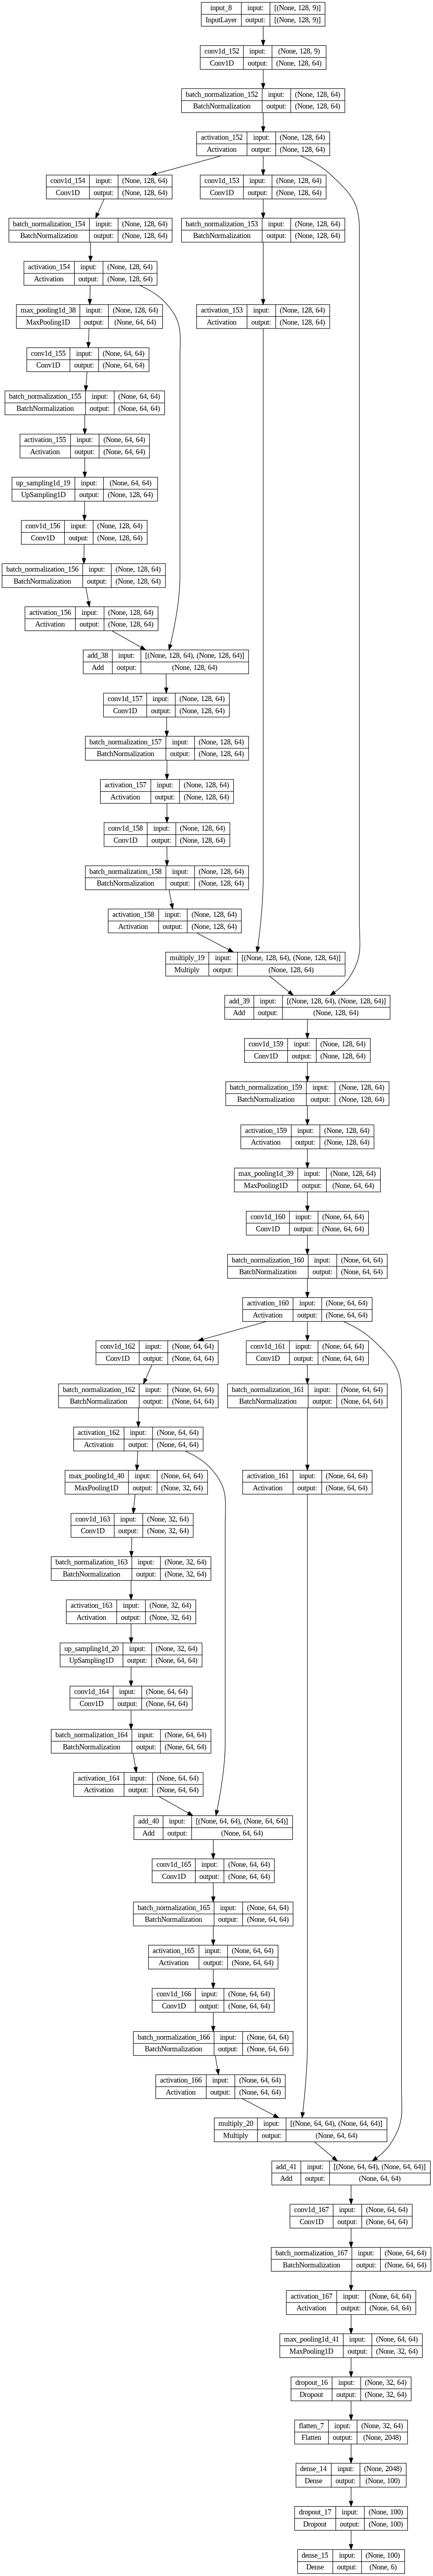

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/100
58/58 [==============================] - 21s 80ms/step - loss: 0.9414 - accuracy: 0.6604 - val_loss: 1.7343 - val_accuracy: 0.6587
Epoch 2/100
58/58 [==============================] - 3s 51ms/step - loss: 0.2291 - accuracy: 0.9191 - val_loss: 0.5949 - val_accuracy: 0.8613
Epoch 3/100
58/58 [==============================] - 3s 51ms/step - loss: 0.1714 - accuracy: 0.9350 - val_loss: 0.2423 - val_accuracy: 0.9275
Epoch 4/100
58/58 [==============================] - 3s 55ms/step - loss: 0.1823 - accuracy: 0.9328 - val_loss: 0.1454 - val_accuracy: 0.9474
Epoch 5/100
58/58 [==============================] - 3s 50ms/step - loss: 0.1504 - accuracy: 0.9376 - val_loss: 0.1181 - val_accuracy: 0.9583
Epoch 6/100
58/58 [==============================] - 3s 51ms/step - loss: 0.1356 - accuracy: 0.9440 - val_loss: 0.1266 - val_accuracy: 0.9574
Epoch 7/100
58/58 [==============================] - 3s 51ms/step - loss: 0.1379 - accuracy: 0.9429 - val_loss: 0.1110 - val_accuracy: 0.9538
Epoch

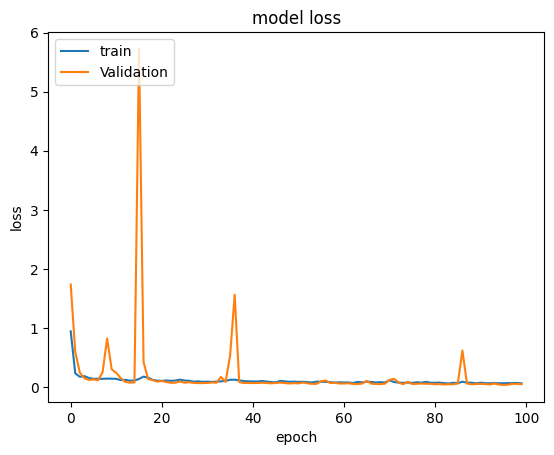

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

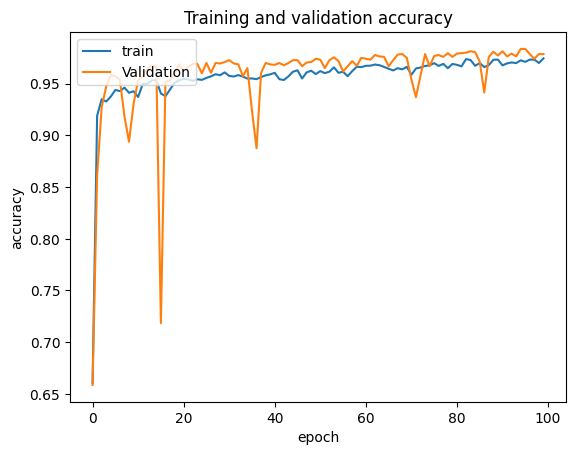

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 7ms/step
[[470   0  26   0   0   0]
 [  3 450  18   0   0   0]
 [  0   0 420   0   0   0]
 [  0  20   0 375  96   0]
 [  0   0   0  50 482   0]
 [  0   0   0   0   0 537]]
0.9277231082456736
0.9269677447992146
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       496
           1       0.96      0.96      0.96       471
           2       0.91      1.00      0.95       420
           3       0.88      0.76      0.82       491
           4       0.83      0.91      0.87       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



<Axes: >

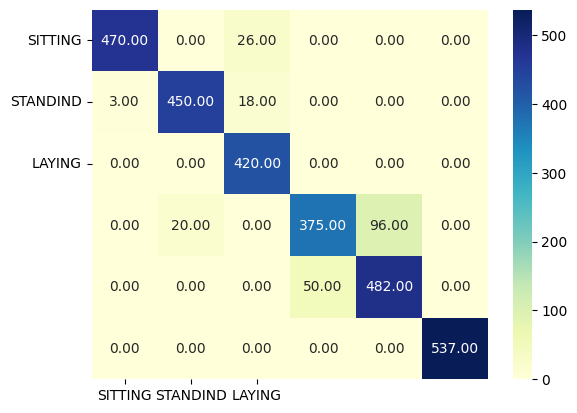

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING','']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

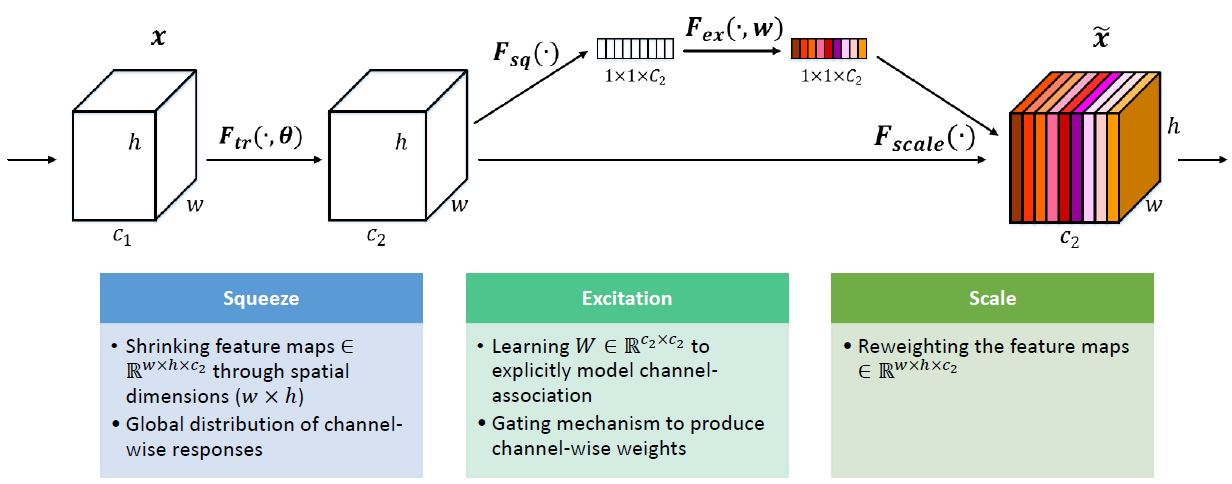

In [ ]:
# SE block은 채널 마다 가중치를 주어 합성곱을 수행
# 채널 간의 의존성을 고려하여 효과적인 특성 강조를 수행하는 방법 동입
# squeeze : Global average pooling을 사용하여 채널별로 평균값을 계산하여 각 채널의 중요도를 파악한다.
# excitation : Fully connected layer , 활성화함수를 통해서 각 채널의 가중치 조정, 채널 같의 관계 모델링
def se_block(in_x, nb_filter):
        # GAP층 사용하여 (특징 맵에서 각 채널의 평균으로 축소)
        squeeze = GlobalAveragePooling1D()(in_x)
        # flatten 층 없이 cnn의 특성 맵을 직접 dense층에 입력 -> 공간 정보를 유지한 채로 전달한다.
        excitation = Dense(units=nb_filter // 2)(squeeze)
        # 필터의 개수는 입력 -> 출력에서 얼마다 다운샘플링 하는지 비율을 뜻한다.
        excitation = Activation('relu')(excitation)
        excitation = Dense(units=nb_filter)(excitation)
        excitation = Activation('sigmoid')(excitation)
        excitation = Reshape((1,nb_filter))(excitation)
        # 처음 필터의 개수 ( 채널 수)로 reshape하여 각 채널의 중요도(가중치)를 채널에 곱하는 연산을 수행
        scale = multiply([in_x,excitation])
        out = add([in_x, scale])

        return out

In [ ]:
def SENET():

    inputs = Input(shape=(n_timesteps,n_features))
    # (none, 128, 9)
    x = Conv1D(16, 32, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 16)
    x = MaxPooling1D(4)(x)

    x = Conv1D(32, 16, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 32)
    x = MaxPooling1D(4)(x)

    #x = Conv1D(64, 9, padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    #x = se_block(x, 64)
    #x = MaxPooling1D(2)(x)

    #x = Conv1D(64, 9, padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    #x = se_block(x, 64)
    #x = MaxPooling1D(2)(x)

    #x = Conv1D(128, 3, padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    #x = se_block(x, 128)
    #x = MaxPooling1D(2)(x)

    #x = Conv1D(128, 3, padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    #x = se_block(x, 128)
    #x = MaxPooling1D(2)(x)

    x = Flatten()(x)
    x = Dense(300,  activation='relu')(x)
    x = Dense(n_outputs,  activation='softmax')(x)

    model = keras.Model(inputs, x)

    return model

In [ ]:
model = SENET()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 conv1d_6 (Conv1D)           (None, 128, 16)              4624      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 128, 16)              64        ['conv1d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_18 (Activation)  (None, 128, 16)              0         ['batch_normalization_6[

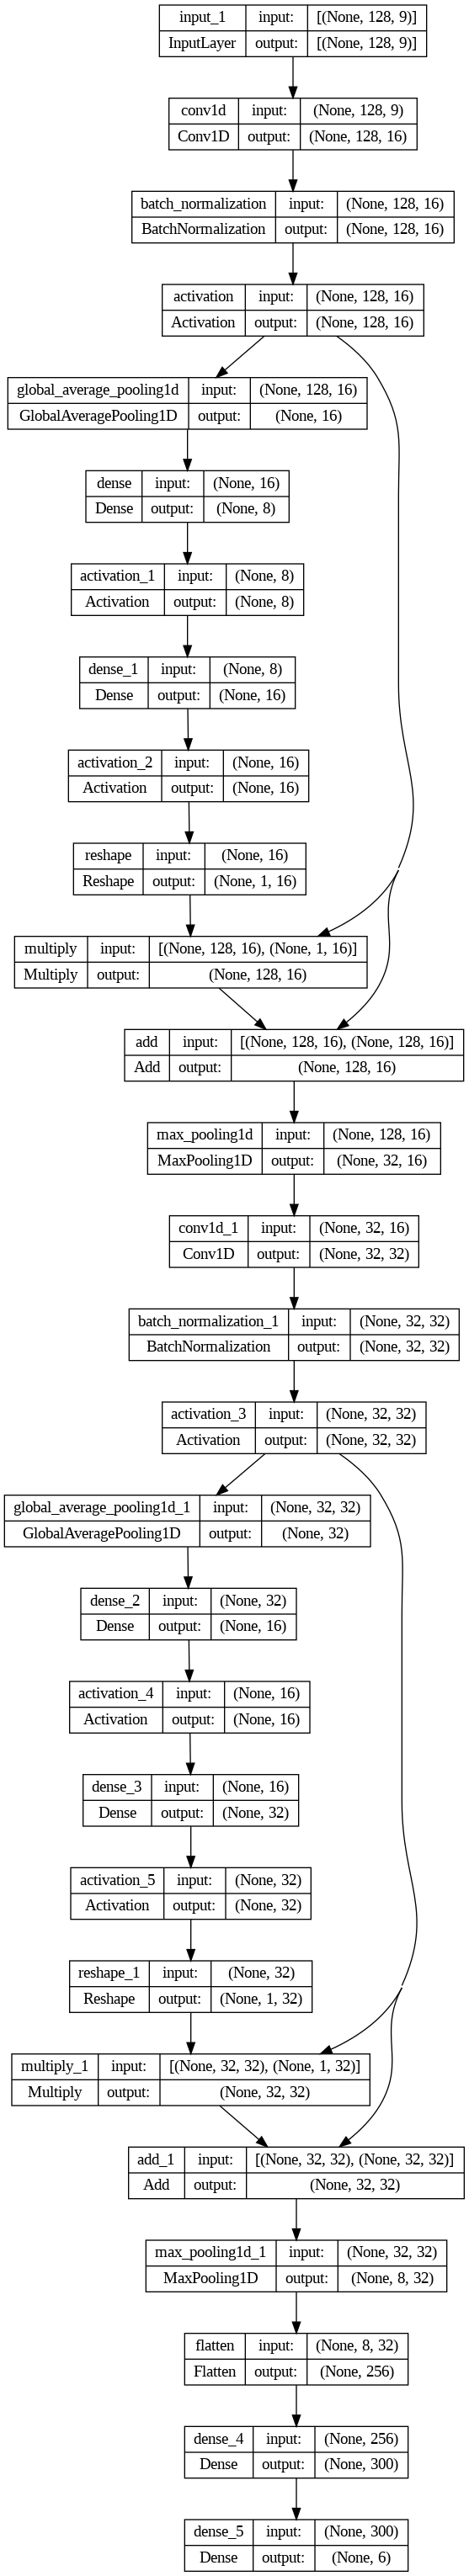

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# validation_split = 0.1
batch_size = 32

train_epochs = 100
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/100
230/230 [==============================] - 10s 22ms/step - loss: 0.2697 - accuracy: 0.8968 - val_loss: 0.1101 - val_accuracy: 0.9610
Epoch 2/100
230/230 [==============================] - 4s 16ms/step - loss: 0.1342 - accuracy: 0.9452 - val_loss: 0.1408 - val_accuracy: 0.9465
Epoch 3/100
230/230 [==============================] - 5s 21ms/step - loss: 0.1284 - accuracy: 0.9479 - val_loss: 0.1075 - val_accuracy: 0.9601
Epoch 4/100
230/230 [==============================] - 4s 17ms/step - loss: 0.1320 - accuracy: 0.9480 - val_loss: 0.1143 - val_accuracy: 0.9510
Epoch 5/100
230/230 [==============================] - 4s 16ms/step - loss: 0.1277 - accuracy: 0.9475 - val_loss: 0.1114 - val_accuracy: 0.9492
Epoch 6/100
230/230 [==============================] - 4s 16ms/step - loss: 0.1181 - accuracy: 0.9470 - val_loss: 0.1019 - val_accuracy: 0.9565
Epoch 7/100
230/230 [==============================] - 5s 22ms/step - loss: 0.1131 - accuracy: 0.9536 - val_loss: 0.1160 - val_accuracy

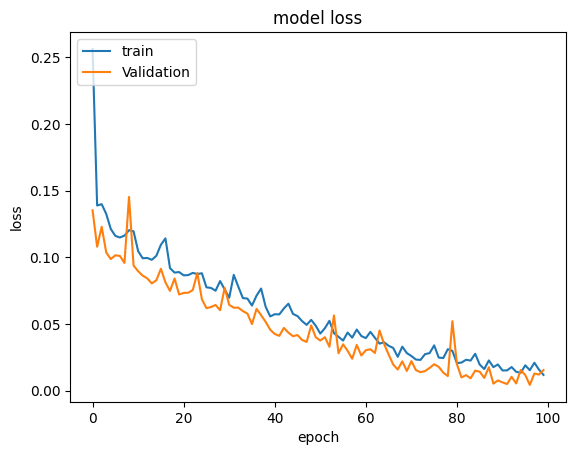

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

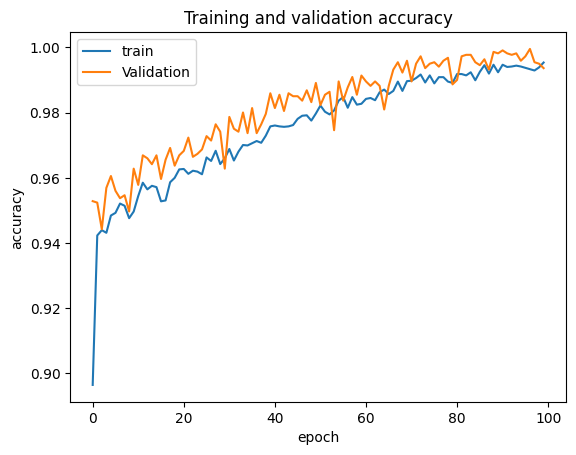

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 0s 2ms/step
[[480   1  15   0   0   0]
 [  0 470   1   0   0   0]
 [  0   0 419   1   0   0]
 [  0   2   0 417  67   5]
 [  2   1   0  17 512   0]
 [  0   0   0   0   0 537]]
0.9619952494061758
0.961689238660287
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       496
           1       0.99      1.00      0.99       471
           2       0.96      1.00      0.98       420
           3       0.96      0.85      0.90       491
           4       0.88      0.96      0.92       532
           5       0.99      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



<Axes: >

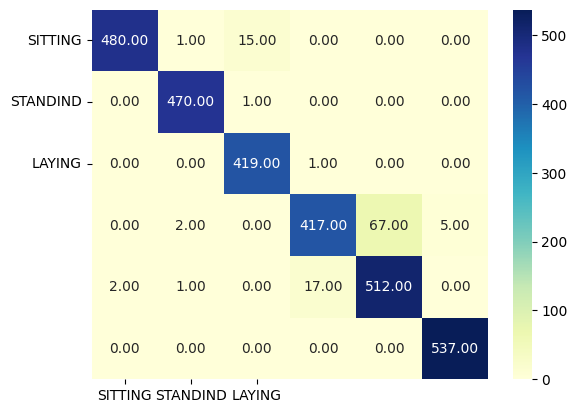

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [ ]:
def RESNET50():

    inputs = Input(shape=(n_timesteps,n_features))

    filter_num = 64

    x = Conv1D(filter_num, 3, strides=2, kernel_initializer="he_normal")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(3, strides=2)(x)

    x = convolutional_block(x, [filter_num, filter_num, filter_num * 4], 4)
    x = identity_block(x, [filter_num, filter_num, filter_num * 4])
    x = identity_block(x, [filter_num, filter_num, filter_num * 4])

    x = convolutional_block(x, [filter_num * 2, filter_num * 2, filter_num * 8], 4)
    x = identity_block(x, [filter_num * 2, filter_num * 2, filter_num * 8])
    x = identity_block(x, [filter_num * 2, filter_num * 2, filter_num * 8])
    x = identity_block(x, [filter_num * 2, filter_num * 2, filter_num * 8])

    x = convolutional_block(x, [filter_num * 4, filter_num * 4, filter_num * 16], 2)
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])

    x = convolutional_block(x, [filter_num * 8, filter_num * 8, filter_num * 32], 2)
    x = identity_block(x, [filter_num * 8, filter_num * 8, filter_num * 32])
    x = identity_block(x, [filter_num * 8, filter_num * 8, filter_num * 32])

    x = GlobalAveragePooling1D()(x)
    x = Dense(500, activation="relu", kernel_initializer="he_normal")(x)
    x = Dense(n_outputs, activation="softmax")(x)

    model = keras.Model(inputs, x)

    return model

In [ ]:
model = RESNET50()


NameError: ignored

In [ ]:
epsilon = 1.e-7
gamma = float(0.3)
1. - epsilon

0.9999999

In [ ]:
def en_loss(y_true, y_pred):

    epsilon = 1.e-7
    gamma = float(0.3)

    y_true = tf.cast(y_true, tf.float32)
    # 텐서의 데이터 타입 변경
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    # 텐서의 값을 지정된 범위로 제한. : y_pred의 값을 epsilon과 1. - epsilon 사이
    pos_pred = tf.pow(-tf.log(y_pred),gamma)
    nag_pred = tf.pow(-tf.log(1-y_pred),gamma)
    y_t = tf.multiply(y_true, pos_pred) + tf.multiply(1-y_true, nag_pred)
    en_loss = tf.reduce_mean(y_t)
    return en_loss

In [ ]:
model = SENET()
model.summary()
model.compile(optimizer = 'adam', loss=en_loss, metrics = ["accuracy"])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 conv1d_4 (Conv1D)           (None, 128, 16)              4624      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 128, 16)              64        ['conv1d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_12 (Activation)  (None, 128, 16)              0         ['batch_normalization_4[

In [ ]:
# validation_split = 0.1
batch_size = 32

train_epochs = 100
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/100
230/230 [==============================] - 8s 17ms/step - loss: 0.2579 - accuracy: 0.8983 - val_loss: 0.1199 - val_accuracy: 0.9501
Epoch 2/100
230/230 [==============================] - 5s 22ms/step - loss: 0.1441 - accuracy: 0.9418 - val_loss: 0.1424 - val_accuracy: 0.9343
Epoch 3/100
230/230 [==============================] - 4s 16ms/step - loss: 0.1272 - accuracy: 0.9476 - val_loss: 0.1160 - val_accuracy: 0.9506
Epoch 4/100
230/230 [==============================] - 4s 16ms/step - loss: 0.1179 - accuracy: 0.9497 - val_loss: 0.1028 - val_accuracy: 0.9560
Epoch 5/100
230/230 [==============================] - 4s 19ms/step - loss: 0.1203 - accuracy: 0.9494 - val_loss: 0.1022 - val_accuracy: 0.9628
Epoch 6/100
230/230 [==============================] - 4s 19ms/step - loss: 0.1139 - accuracy: 0.9504 - val_loss: 0.0894 - val_accuracy: 0.9610
Epoch 7/100
230/230 [==============================] - 4s 16ms/step - loss: 0.1070 - accuracy: 0.9563 - val_loss: 0.0926 - val_accuracy:

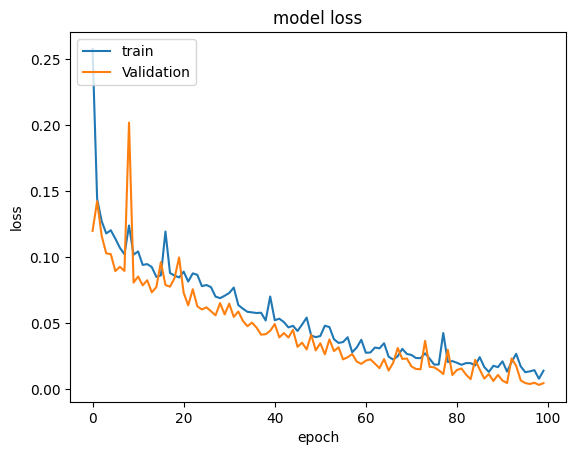

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

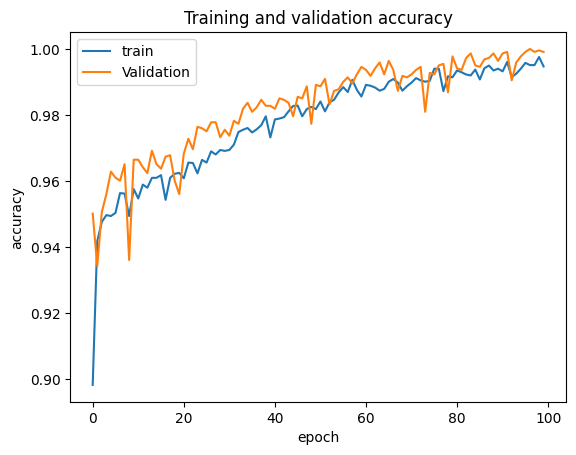

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 7ms/step
[[469   0  26   1   0   0]
 [  0 446  25   0   0   0]
 [  0   0 420   0   0   0]
 [  0   4   0 427  58   2]
 [  0   2   0  23 507   0]
 [  0   0   0   0   0 537]]
0.9521547336274178
0.9522038363734127
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       496
           1       0.99      0.95      0.97       471
           2       0.89      1.00      0.94       420
           3       0.95      0.87      0.91       491
           4       0.90      0.95      0.92       532
           5       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



<Axes: >

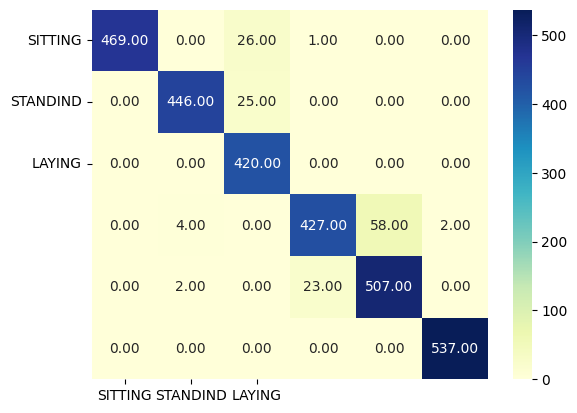

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

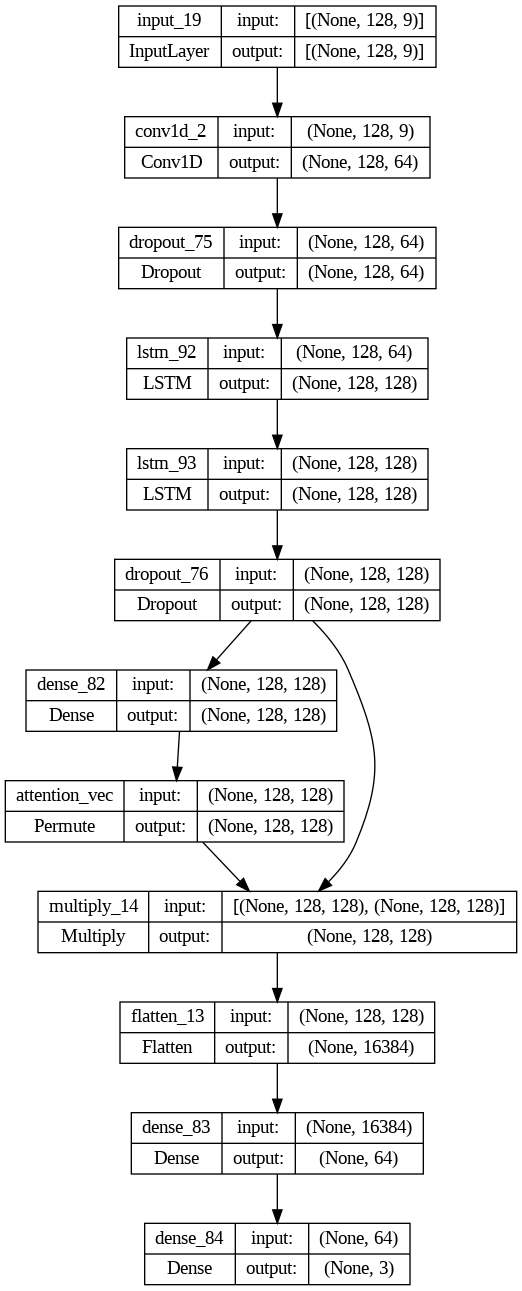

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
import math
import time

start = time.time()
model_history=model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32,validation_data=(X_val,y_val_one_hot))


end = time.time()
print(f"{end - start:.5f} sec")

Epoch 1/100
72/72 [==============================] - 7s 29ms/step - loss: 0.6646 - accuracy: 0.6716 - val_loss: 0.2698 - val_accuracy: 0.9209
Epoch 2/100
72/72 [==============================] - 1s 17ms/step - loss: 0.1336 - accuracy: 0.9604 - val_loss: 0.0379 - val_accuracy: 0.9878
Epoch 3/100
72/72 [==============================] - 2s 24ms/step - loss: 0.0392 - accuracy: 0.9874 - val_loss: 0.0131 - val_accuracy: 0.9959
Epoch 4/100
72/72 [==============================] - 2s 24ms/step - loss: 0.0066 - accuracy: 0.9974 - val_loss: 0.0111 - val_accuracy: 0.9939
Epoch 5/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0372 - accuracy: 0.9891 - val_loss: 0.0441 - val_accuracy: 0.9868
Epoch 6/100
72/72 [==============================] - 1s 17ms/step - loss: 0.0149 - accuracy: 0.9957 - val_loss: 0.0100 - val_accuracy: 0.9959
Epoch 7/100
72/72 [==============================] - 1s 17ms/step - loss: 0.0171 - accuracy: 0.9939 - val_loss: 0.0058 - val_accuracy: 0.9990
Epoch 

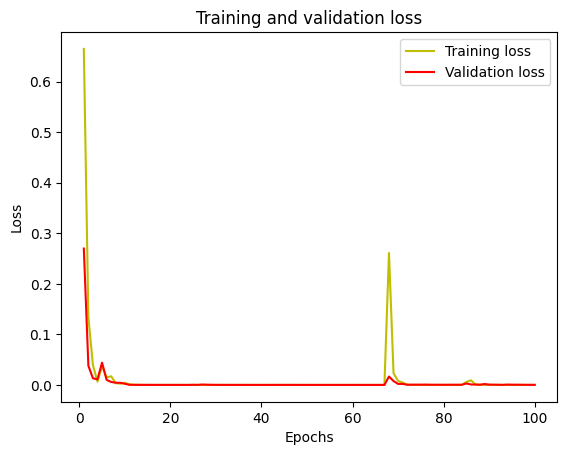

In [ ]:
loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

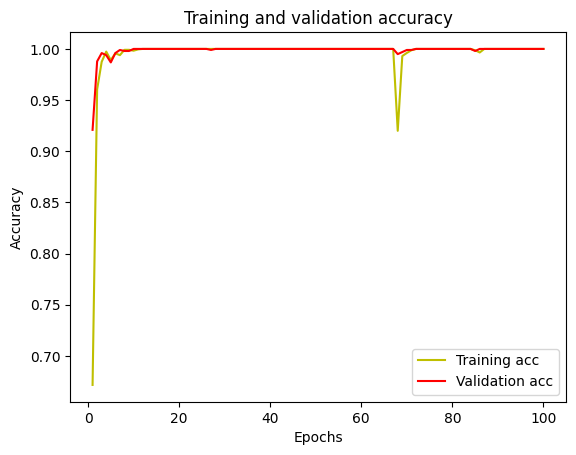

In [ ]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

44/44 [==============================] - 1s 9ms/step
[[487   3   6]
 [  7 459   5]
 [  2   1 417]]
0.9826964671953857
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       496
           1       0.99      0.97      0.98       471
           2       0.97      0.99      0.98       420

    accuracy                           0.98      1387
   macro avg       0.98      0.98      0.98      1387
weighted avg       0.98      0.98      0.98      1387



<Axes: >

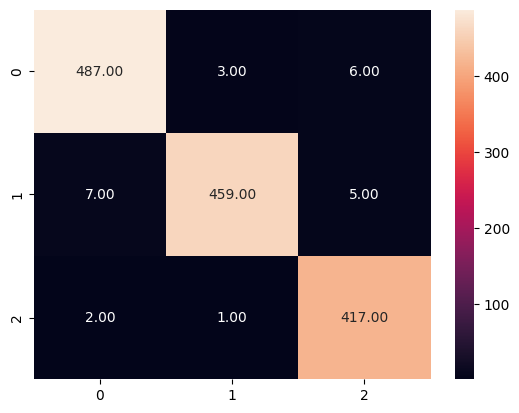

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy = model.predict(testX)
predy = np.argmax(predy, axis=1)

cm= confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(classification_report(testy,predy))
sns.heatmap(cm, annot=True, fmt = '.2f')